# lib

In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# preprocessing data

In [2]:
import pandas_ta as ta

In [3]:
path_to_file = "btc.csv"

In [4]:
btc = pd.read_csv(path_to_file, skiprows=1)
btc = btc[::-1]
# btc = btc[2100:]
btc = btc.astype({'date': 'datetime64'}).set_index('date')
btc = btc.drop(['unix', 'symbol','Volume USD'], axis=1)

btc.head()

,open,high,low,close,Volume BTC
date,,,,,
2014-11-28,363.59,381.34,360.57,376.28,3220878.18
2014-11-29,376.42,386.60,372.25,376.72,2746157.05
2014-11-30,376.57,381.99,373.32,373.34,1145566.61
2014-12-01,376.40,382.31,373.03,378.39,2520662.37
2014-12-02,378.39,382.86,375.23,379.25,2593576.46


<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='date'>

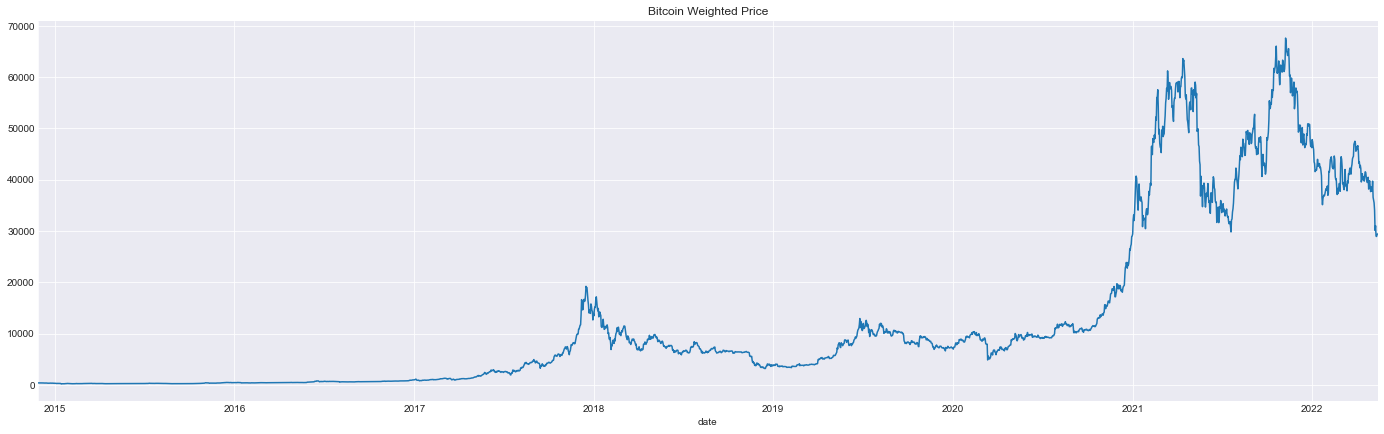

In [5]:
# btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")
btc.close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [6]:

btc['close_log'] =  np.log(btc['close'])
btc['diff1_log'] = btc['close_log'].diff()
btc['diff7_log'] = btc['close_log'].diff(7)
btc['diff30_log'] = btc['close_log'].diff(30)
btc['diff1'] = btc['close'].diff()
btc['diff7'] = btc['close'].diff(7)
btc['diff30'] = btc['close'].diff(30)
# btc['reverse_diff'] = btc['close'].shift(1) + btc['diff']
btc['rsi'] = ta.rsi(btc['close'],length=14)
btc['mom'] = ta.mom(btc['close'],length=10)
btc['target_log'] = btc['close_log'].shift(-1)
btc['target'] = btc['close'].shift(-1)
btc = btc.dropna()

In [7]:
btc.tail()

,open,high,low,close,Volume BTC,close_log,diff1_log,diff7_log,diff30_log,diff1,diff7,diff30,rsi,mom,target_log,target
date,,,,,,,,,,,,,,,,
2022-05-09,34051.20,34224.35,30015.00,30082.00,7631.121662,10.311682,-0.123183,-0.247277,-0.351861,-3943.50,-8439.01,-12685.89,24.506606,-8511.42,10.341742,30999.97
2022-05-10,30066.48,32650.00,29731.03,30999.97,7402.302313,10.341742,0.030059,-0.196468,-0.306865,917.97,-6729.98,-11133.88,28.604810,-6639.83,10.275051,29000.00
2022-05-11,31002.27,32148.15,27757.77,29000.00,11180.848836,10.275051,-0.066690,-0.313683,-0.309634,-1999.97,-10685.23,-10524.86,25.373064,-9488.34,10.271465,28896.19
2022-05-12,28999.99,30090.70,25401.05,28896.19,16578.810599,10.271465,-0.003586,-0.234532,-0.327603,-103.81,-7637.74,-11201.27,25.213830,-9624.82,10.283252,29238.81
2022-05-13,28932.69,30974.60,28686.37,29238.81,6010.273639,10.283252,0.011787,-0.208556,-0.341672,342.62,-6780.41,-11908.93,26.845615,-8491.14,10.288993,29407.14


In [8]:
prediction_days = 60

df_train_= btc[:][:len(btc)-prediction_days]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-prediction_days:]#.values.reshape(-1,1)

# creat data lstm

In [9]:
df_train_.columns

Index(['open', 'high', 'low', 'close', 'Volume BTC', 'close_log', 'diff1_log',
       'diff7_log', 'diff30_log', 'diff1', 'diff7', 'diff30', 'rsi', 'mom',
       'target_log', 'target'],
      dtype='object')

In [10]:
df_train = df_train_[:][['open', 'high', 'low', 'close', 'Volume BTC', 'target']]
df_test = df_test_[:][['open', 'high', 'low', 'close', 'Volume BTC', 'target']]
df_test.head(2)

,open,high,low,close,Volume BTC,target
date,,,,,,
2022-03-15,39688.55,39896.13,38142.35,39302.70,1638.684030,41142.76
2022-03-16,39302.80,41693.97,38865.67,41142.76,5987.103889,40963.22


In [11]:
def scl(df):
    q = df[0]
    dq = []
    for i in range(len(df)):
        dq.append(q)
    df = (np.array(df) / np.array(dq)) - 1
    return df, q

In [12]:
# many to one

look_back_ = 5

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
    sequential_data = [] 
    prev_days = deque(maxlen=look_back)
    for i in dataset.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == look_back:  
            prev_days_, q = scl(prev_days)
            if i[-1] > prev_days[-1][3]:
                target = 1
            else :
                target = 0
            sequential_data.append([np.array(prev_days_), target])
    dataX=[]
    dataY=[]
    for seq, target in sequential_data: 
        dataX.append(seq) 
        dataY.append(target) 
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(df_train)
trainX, trainY = trainX[2100:], trainY[2100:]
testX, testY = dataset_generator_lstm(df_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testY: ", testX.shape)
print("testY", testY.shape)

trainX:  (530, 5, 5)
trainY:  (530,)
testY:  (56, 5, 5)
testY (56,)


# train

In [13]:
regressor = Sequential()

regressor.add(LSTM(units = 256,return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 128,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 256))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 64,activation='relu'))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 32,activation='relu'))

regressor.add(Dense(units = 1,activation='softmax'))

regressor.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 256)            268288    
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            197120    
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               394240    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                1

In [19]:
regressor.compile(optimizer = 'adam', loss ='BinaryCrossentropy'   , metrics='accuracy')

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='loss', patience=100, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

history = regressor.fit(trainX, trainY, batch_size = 1028, epochs = 3000, verbose=1, shuffle=False,
                        validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/3000
1/1 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.5302
Epoch 1: loss improved from inf to 0.04609, saving model to my_best_model.hdf5
1/1 [==============================] - 6s 6s/step - loss: 0.0461 - accuracy: 0.5302 - val_loss: 3.0788 - val_accuracy: 0.5000
Epoch 2/3000
1/1 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.5302
Epoch 2: loss did not improve from 0.04609
1/1 [==============================] - 0s 182ms/step - loss: 0.1238 - accuracy: 0.5302 - val_loss: 3.0766 - val_accuracy: 0.5000
Epoch 3/3000
1/1 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.5302
Epoch 3: loss improved from 0.04609 to 0.04513, saving model to my_best_model.hdf5
1/1 [==============================] - 0s 250ms/step - loss: 0.0451 - accuracy: 0.5302 - val_loss: 3.0505 - val_accuracy: 0.5000
Epoch 4/3000
1/1 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.5302
Epoch 4: loss did not improve from 

Epoch 31/3000
1/1 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.5302
Epoch 31: loss did not improve from 0.02897
1/1 [==============================] - 0s 178ms/step - loss: 0.0603 - accuracy: 0.5302 - val_loss: 2.4046 - val_accuracy: 0.5000
Epoch 32/3000
1/1 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.5302
Epoch 32: loss did not improve from 0.02897
1/1 [==============================] - 0s 188ms/step - loss: 0.0455 - accuracy: 0.5302 - val_loss: 2.4850 - val_accuracy: 0.5000
Epoch 33/3000
1/1 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.5302
Epoch 33: loss did not improve from 0.02897
1/1 [==============================] - 0s 204ms/step - loss: 0.0505 - accuracy: 0.5302 - val_loss: 2.5826 - val_accuracy: 0.5000
Epoch 34/3000
1/1 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.5302
Epoch 34: loss did not improve from 0.02897
1/1 [==============================] - 0s 188ms/step - lo

1/1 [==============================] - 0s 214ms/step - loss: 0.0289 - accuracy: 0.5302 - val_loss: 2.8539 - val_accuracy: 0.5000
Epoch 62/3000
1/1 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.5302
Epoch 62: loss did not improve from 0.02828
1/1 [==============================] - 0s 230ms/step - loss: 0.0413 - accuracy: 0.5302 - val_loss: 2.9159 - val_accuracy: 0.5000
Epoch 63/3000
1/1 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.5302
Epoch 63: loss did not improve from 0.02828
1/1 [==============================] - 0s 218ms/step - loss: 0.0399 - accuracy: 0.5302 - val_loss: 2.9921 - val_accuracy: 0.5000
Epoch 64/3000
1/1 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.5302
Epoch 64: loss did not improve from 0.02828
1/1 [==============================] - 0s 186ms/step - loss: 0.0454 - accuracy: 0.5302 - val_loss: 3.0310 - val_accuracy: 0.5000
Epoch 65/3000
1/1 [==============================] - ETA: 0s - loss

Epoch 92/3000
1/1 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.5302
Epoch 92: loss improved from 0.01864 to 0.01604, saving model to my_best_model.hdf5
1/1 [==============================] - 0s 261ms/step - loss: 0.0160 - accuracy: 0.5302 - val_loss: 2.6141 - val_accuracy: 0.5000
Epoch 93/3000
1/1 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.5302
Epoch 93: loss did not improve from 0.01604
1/1 [==============================] - 0s 195ms/step - loss: 0.0461 - accuracy: 0.5302 - val_loss: 2.6383 - val_accuracy: 0.5000
Epoch 94/3000
1/1 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.5302
Epoch 94: loss did not improve from 0.01604
1/1 [==============================] - 0s 210ms/step - loss: 0.0204 - accuracy: 0.5302 - val_loss: 2.6970 - val_accuracy: 0.5000
Epoch 95/3000
1/1 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.5302
Epoch 95: loss did not improve from 0.01604
1/1 [============

1/1 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.5302
Epoch 122: loss did not improve from 0.01604
1/1 [==============================] - 0s 194ms/step - loss: 0.0187 - accuracy: 0.5302 - val_loss: 3.3308 - val_accuracy: 0.5000
Epoch 123/3000
1/1 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.5302
Epoch 123: loss did not improve from 0.01604
1/1 [==============================] - 0s 214ms/step - loss: 0.0256 - accuracy: 0.5302 - val_loss: 3.2184 - val_accuracy: 0.5000
Epoch 124/3000
1/1 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.5302
Epoch 124: loss did not improve from 0.01604
1/1 [==============================] - 0s 184ms/step - loss: 0.0187 - accuracy: 0.5302 - val_loss: 3.0367 - val_accuracy: 0.5000
Epoch 125/3000
1/1 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.5302
Epoch 125: loss did not improve from 0.01604
1/1 [==============================] - 0s 202ms/step - loss: 0.0

1/1 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.5302
Epoch 152: loss did not improve from 0.01490
1/1 [==============================] - 0s 204ms/step - loss: 0.0327 - accuracy: 0.5302 - val_loss: 2.9730 - val_accuracy: 0.5000
Epoch 153/3000
1/1 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.5302
Epoch 153: loss did not improve from 0.01490
1/1 [==============================] - 0s 225ms/step - loss: 0.0345 - accuracy: 0.5302 - val_loss: 2.8480 - val_accuracy: 0.5000
Epoch 154/3000
1/1 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.5302
Epoch 154: loss did not improve from 0.01490
1/1 [==============================] - 0s 217ms/step - loss: 0.0197 - accuracy: 0.5302 - val_loss: 2.7480 - val_accuracy: 0.5000
Epoch 155/3000
1/1 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.5302
Epoch 155: loss did not improve from 0.01490
1/1 [==============================] - 0s 220ms/step - loss: 0.0

1/1 [==============================] - 0s 224ms/step - loss: 0.0441 - accuracy: 0.5302 - val_loss: 2.7873 - val_accuracy: 0.5000
Epoch 183/3000
1/1 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.5302
Epoch 183: loss did not improve from 0.01490
1/1 [==============================] - 0s 208ms/step - loss: 0.0208 - accuracy: 0.5302 - val_loss: 2.7660 - val_accuracy: 0.5000
Epoch 184/3000
1/1 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.5302
Epoch 184: loss did not improve from 0.01490
1/1 [==============================] - 0s 183ms/step - loss: 0.0296 - accuracy: 0.5302 - val_loss: 2.7114 - val_accuracy: 0.5000
Epoch 185/3000
1/1 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.5302
Epoch 185: loss did not improve from 0.01490
1/1 [==============================] - 0s 183ms/step - loss: 0.0396 - accuracy: 0.5302 - val_loss: 2.6758 - val_accuracy: 0.5000
Epoch 186/3000
1/1 [==============================] - ETA: 0s

Epoch 213/3000
1/1 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.5302
Epoch 213: loss did not improve from 0.01490
1/1 [==============================] - 0s 176ms/step - loss: 0.0444 - accuracy: 0.5302 - val_loss: 2.6187 - val_accuracy: 0.5000
Epoch 214/3000
1/1 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.5302
Epoch 214: loss did not improve from 0.01490
1/1 [==============================] - 0s 169ms/step - loss: 0.0265 - accuracy: 0.5302 - val_loss: 2.5918 - val_accuracy: 0.5000
Epoch 215/3000
1/1 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.5302
Epoch 215: loss did not improve from 0.01490
1/1 [==============================] - 0s 172ms/step - loss: 0.0243 - accuracy: 0.5302 - val_loss: 2.5881 - val_accuracy: 0.5000
Epoch 216/3000
1/1 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.5302
Epoch 216: loss did not improve from 0.01490
1/1 [==============================] - 0s 171ms/s

1/1 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.5302
Epoch 243: loss did not improve from 0.01490
1/1 [==============================] - 0s 186ms/step - loss: 0.0441 - accuracy: 0.5302 - val_loss: 2.7947 - val_accuracy: 0.5000
Epoch 244/3000
1/1 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.5302
Epoch 244: loss did not improve from 0.01490
1/1 [==============================] - 0s 178ms/step - loss: 0.0207 - accuracy: 0.5302 - val_loss: 2.8360 - val_accuracy: 0.5000
Epoch 245/3000
1/1 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.5302
Epoch 245: loss did not improve from 0.01490
1/1 [==============================] - 0s 182ms/step - loss: 0.0266 - accuracy: 0.5302 - val_loss: 2.7875 - val_accuracy: 0.5000
Epoch 246/3000
1/1 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.5302
Epoch 246: loss improved from 0.01490 to 0.01130, saving model to my_best_model.hdf5
1/1 [===================

1/1 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.5302
Epoch 273: loss did not improve from 0.01130
1/1 [==============================] - 0s 194ms/step - loss: 0.0339 - accuracy: 0.5302 - val_loss: 3.1156 - val_accuracy: 0.5000
Epoch 274/3000
1/1 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.5302
Epoch 274: loss did not improve from 0.01130
1/1 [==============================] - 0s 203ms/step - loss: 0.0267 - accuracy: 0.5302 - val_loss: 3.1273 - val_accuracy: 0.5000
Epoch 275/3000
1/1 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.5302
Epoch 275: loss did not improve from 0.01130
1/1 [==============================] - 0s 196ms/step - loss: 0.0326 - accuracy: 0.5302 - val_loss: 3.1289 - val_accuracy: 0.5000
Epoch 276/3000
1/1 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.5302
Epoch 276: loss did not improve from 0.01130
1/1 [==============================] - 0s 198ms/step - loss: 0.0

1/1 [==============================] - 0s 181ms/step - loss: 0.0281 - accuracy: 0.5302 - val_loss: 3.4144 - val_accuracy: 0.5000
Epoch 304/3000
1/1 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.5302
Epoch 304: loss did not improve from 0.01130
1/1 [==============================] - 0s 183ms/step - loss: 0.0220 - accuracy: 0.5302 - val_loss: 3.3891 - val_accuracy: 0.5000
Epoch 305/3000
1/1 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.5302
Epoch 305: loss did not improve from 0.01130
1/1 [==============================] - 0s 175ms/step - loss: 0.0199 - accuracy: 0.5302 - val_loss: 3.3868 - val_accuracy: 0.5000
Epoch 306/3000
1/1 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.5302
Epoch 306: loss did not improve from 0.01130
1/1 [==============================] - 0s 174ms/step - loss: 0.0205 - accuracy: 0.5302 - val_loss: 3.3658 - val_accuracy: 0.5000
Epoch 307/3000
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 203ms/step - loss: 0.0114 - accuracy: 0.5302 - val_loss: 3.8466 - val_accuracy: 0.5000
Epoch 334/3000
1/1 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.5302
Epoch 334: loss did not improve from 0.00863
1/1 [==============================] - 0s 213ms/step - loss: 0.0237 - accuracy: 0.5302 - val_loss: 3.9484 - val_accuracy: 0.5000
Epoch 335/3000
1/1 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.5302
Epoch 335: loss did not improve from 0.00863
1/1 [==============================] - 0s 203ms/step - loss: 0.0350 - accuracy: 0.5302 - val_loss: 3.8554 - val_accuracy: 0.5000
Epoch 336/3000
1/1 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.5302
Epoch 336: loss did not improve from 0.00863
1/1 [==============================] - 0s 193ms/step - loss: 0.0592 - accuracy: 0.5302 - val_loss: 3.6324 - val_accuracy: 0.5000
Epoch 337/3000
1/1 [==============================] - ETA: 0s

Epoch 364/3000
1/1 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.5302
Epoch 364: loss did not improve from 0.00724
1/1 [==============================] - 0s 179ms/step - loss: 0.0186 - accuracy: 0.5302 - val_loss: 3.2127 - val_accuracy: 0.5000
Epoch 365/3000
1/1 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.5302
Epoch 365: loss did not improve from 0.00724
1/1 [==============================] - 0s 192ms/step - loss: 0.0179 - accuracy: 0.5302 - val_loss: 3.2343 - val_accuracy: 0.5000
Epoch 366/3000
1/1 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.5302
Epoch 366: loss did not improve from 0.00724
1/1 [==============================] - 0s 202ms/step - loss: 0.0237 - accuracy: 0.5302 - val_loss: 3.2335 - val_accuracy: 0.5000
Epoch 367/3000
1/1 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.5302
Epoch 367: loss did not improve from 0.00724
1/1 [==============================] - 0s 188ms/s

1/1 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.5302
Epoch 394: loss did not improve from 0.00724
1/1 [==============================] - 0s 203ms/step - loss: 0.0292 - accuracy: 0.5302 - val_loss: 3.4249 - val_accuracy: 0.5000
Epoch 395/3000
1/1 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.5302
Epoch 395: loss did not improve from 0.00724
1/1 [==============================] - 0s 187ms/step - loss: 0.0166 - accuracy: 0.5302 - val_loss: 3.4349 - val_accuracy: 0.5000
Epoch 396/3000
1/1 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.5302
Epoch 396: loss did not improve from 0.00724
1/1 [==============================] - 0s 200ms/step - loss: 0.0390 - accuracy: 0.5302 - val_loss: 3.3417 - val_accuracy: 0.5000
Epoch 397/3000
1/1 [==============================] - ETA: 0s - loss: 0.0355 - accuracy: 0.5302
Epoch 397: loss did not improve from 0.00724
1/1 [==============================] - 0s 217ms/step - loss: 0.0

1/1 [==============================] - 0s 181ms/step - loss: 0.0278 - accuracy: 0.5302 - val_loss: 3.5095 - val_accuracy: 0.5000
Epoch 425/3000
1/1 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.5302
Epoch 425: loss did not improve from 0.00724
1/1 [==============================] - 0s 185ms/step - loss: 0.0189 - accuracy: 0.5302 - val_loss: 3.5557 - val_accuracy: 0.5000
Epoch 426/3000
1/1 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.5302
Epoch 426: loss did not improve from 0.00724
1/1 [==============================] - 0s 181ms/step - loss: 0.0222 - accuracy: 0.5302 - val_loss: 3.5480 - val_accuracy: 0.5000
Epoch 427/3000
1/1 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.5302
Epoch 427: loss did not improve from 0.00724
1/1 [==============================] - 0s 179ms/step - loss: 0.0360 - accuracy: 0.5302 - val_loss: 3.4382 - val_accuracy: 0.5000
Epoch 428/3000
1/1 [==============================] - ETA: 0s

Epoch 455/3000
1/1 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.5302
Epoch 455: loss did not improve from 0.00724
1/1 [==============================] - 0s 190ms/step - loss: 0.0259 - accuracy: 0.5302 - val_loss: 2.8769 - val_accuracy: 0.5000
Epoch 456/3000
1/1 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.5302
Epoch 456: loss did not improve from 0.00724
1/1 [==============================] - 0s 190ms/step - loss: 0.0217 - accuracy: 0.5302 - val_loss: 2.8464 - val_accuracy: 0.5000
Epoch 457/3000
1/1 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.5302
Epoch 457: loss did not improve from 0.00724
1/1 [==============================] - 0s 200ms/step - loss: 0.0192 - accuracy: 0.5302 - val_loss: 2.8369 - val_accuracy: 0.5000
Epoch 458/3000
1/1 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.5302
Epoch 458: loss did not improve from 0.00724
1/1 [==============================] - 0s 205ms/s

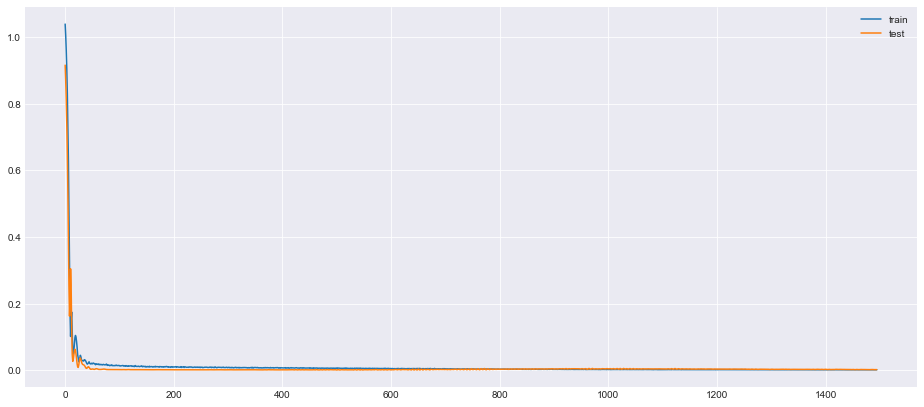

In [46]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [47]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model('my_best_model.hdf5')

# test test

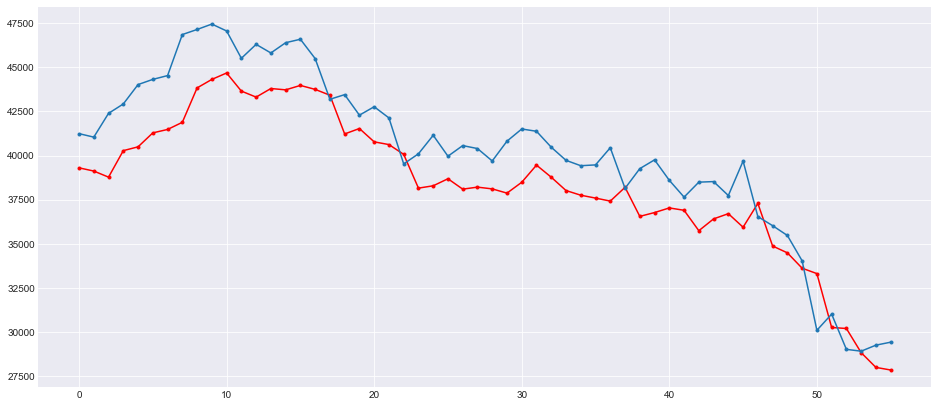

In [48]:
plt.figure(figsize=(16,7))

predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
testY_ = testY.copy()

for i in range(len(predicted_btc_price_test_data)):
    predicted_btc_price_test_data[i] = ((predicted_btc_price_test_data[i] * testX__[i][0][3]) )
    testY_[i] = ((testY[i] * testX__[i][0][3]))
    
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(testY_, marker='.', label='Actual Test')

# test train

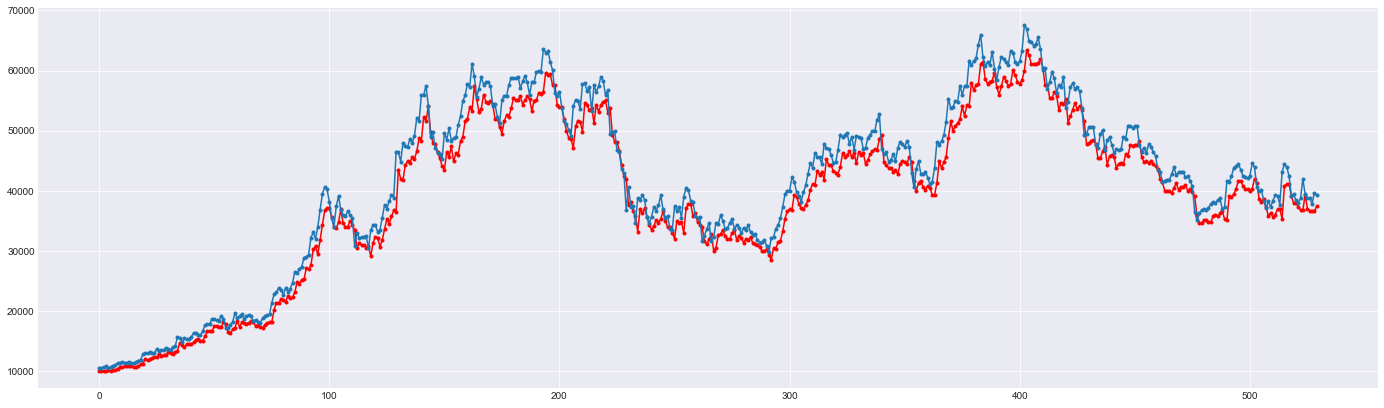

In [49]:
plt.figure(figsize=(24,7))

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
trainY_ =trainY.copy()

for i in range(len(predicted_btc_price_train_data)):
    predicted_btc_price_train_data[i] = predicted_btc_price_train_data[i] * trainX__[i][0][3]
    trainY_[i] = trainY[i] * trainX__[i][0][3]


plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
plt.plot(trainY_, marker='.', label='Actual Test')